In [1]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle competitions download -c titanic

Saving kaggle.json to kaggle.json
ref                                                       title                                               size  lastUpdated          downloadCount  
--------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
thomaskonstantin/highly-rated-children-books-and-stories  Highly Rated Children Books And Stories            106KB  2020-10-24 12:09:59             62  
rishidamarla/judicial-expenditures-across-all-50-states   Judicial Expenditures across all 50 States           2KB  2020-10-25 00:07:45             34  
kanishk307/6000-indian-food-recipes-dataset               6000+ Indian Food Recipes Dataset                    9MB  2020-10-24 01:08:23             87  
balraj98/synthetic-objective-testing-set-sots-reside      Synthetic Objective Testing Set (SOTS) [RESIDE]    415MB  2020-10-24 10:07:29              6  
salmaneunus/mechanical-tools-dataset            

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                             GradientBoostingClassifier, ExtraTreesClassifier,
                             VotingClassifier)
from sklearn.model_selection import (GridSearchCV, cross_val_score, cross_val_predict,
                                     StratifiedKFold, learning_curve)

from sklearn.metrics import (confusion_matrix, accuracy_score) 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import warnings
from collections import Counter

sns.set(style='white', context='notebook', palette='deep')
warnings.filterwarnings('ignore', category = DeprecationWarning)


# Preparing Data

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

TestPassengerID = test['PassengerId']

In [4]:
train.shape

(891, 12)

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [13]:
def find_missing_data(data):
    Total = data.isnull().sum().sort_values(ascending=False)
    Percentage = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
    return pd.concat([Total, Percentage] , axis = 1 , keys = ['Total' , 'Percent'])

find_missing_data(train)

,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


In [14]:
ыns.heatmap(train.isnull())

NameError: ignored

In [15]:
find_missing_data(dataset)

,Total,Percent
Cabin,1014,0.774637
Survived,418,0.319328
Age,263,0.200917
Embarked,2,0.001528
Fare,1,0.000764
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000


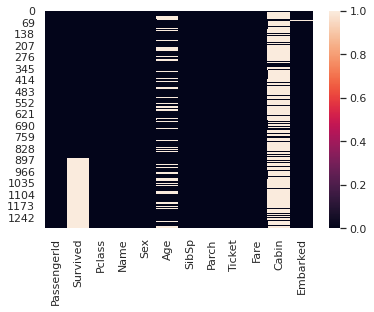

In [16]:
sns.heatmap(dataset.isnull())

# Feature Analysis

In [19]:
def detect_outliers(df,n,features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col],75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)  
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers   

Outliers_to_drop = detect_outliers(train, 2, ["Age", "SibSp", "Parch", "Fare"])

In [20]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [23]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

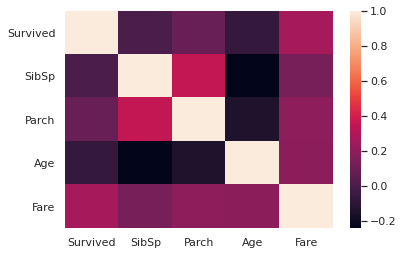

In [24]:
corr_numeric = sns.heatmap(dataset[["Survived","SibSp","Parch","Age","Fare"]].corr())

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


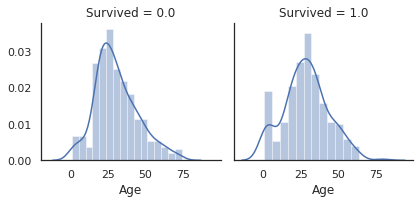

In [25]:
age_survived = sns.FacetGrid(dataset, col='Survived')
age_survived = age_survived.map(sns.distplot, "Age")

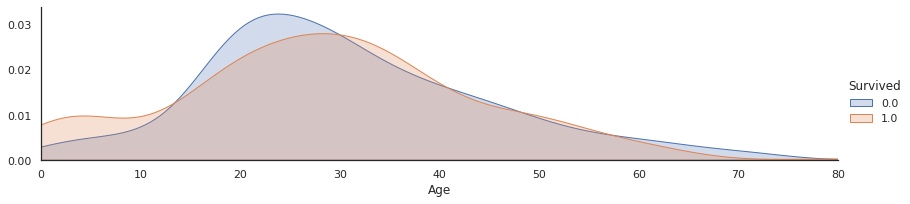

In [30]:
fig = sns.FacetGrid(dataset, hue='Survived', aspect=4)
fig.map(sns.kdeplot, 'Age', shade = True)
fig.set(xlim=(0, dataset['Age'].max()))
fig.add_legend()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


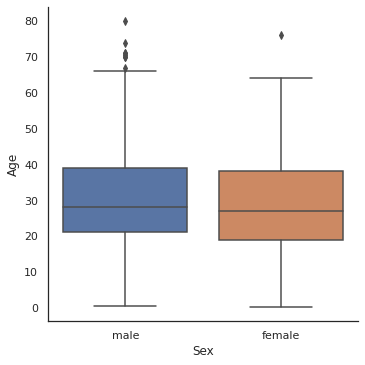

In [32]:
AS = sns.factorplot(y="Age", x="Sex", data=dataset, kind="box")

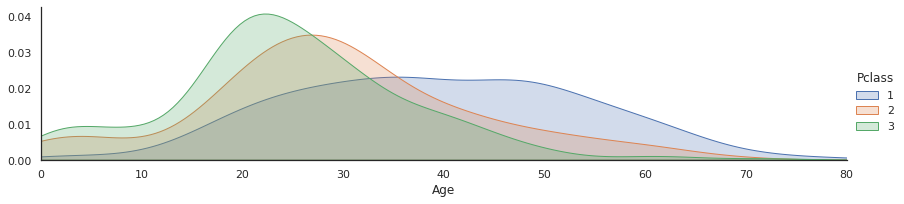

In [33]:
facet = sns.FacetGrid(dataset, hue="Pclass", aspect=4)
facet.map(sns.kdeplot, 'Age', shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


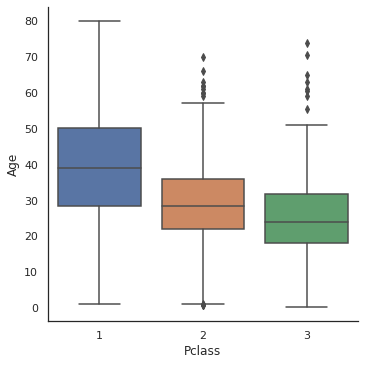

In [34]:
PA = sns.factorplot(data=dataset, x='Pclass', y='Age', kind='box')

In [35]:
def AgeImpute(df):
    Age = df[0]
    Pclass = df[1]
    if pd.isnull(Age):
        if Pclass == 1: return 37
        elif Pclass == 2: return 29
        else: return 24
    else:
        return Age

dataset['Age'] = dataset[['Age' , 'Pclass']].apply(AgeImpute, axis = 1)

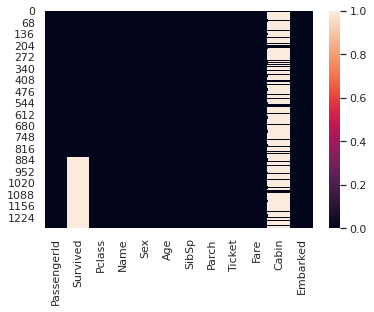

In [37]:
sns.heatmap(dataset.isnull())

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


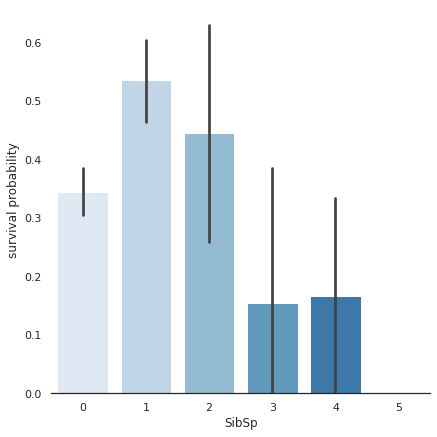

In [39]:
Sib_Sur = sns.factorplot(x="SibSp", y="Survived", data=train, kind="bar", size=6, palette="Blues")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


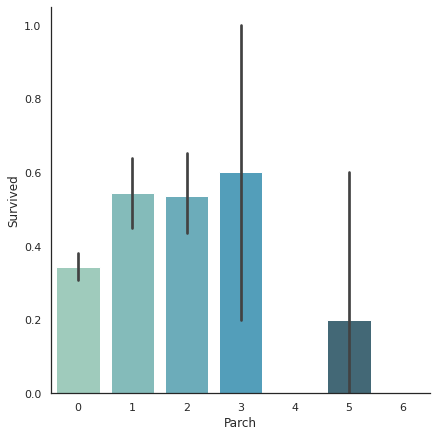

In [40]:
Sur_Par = sns.factorplot(x="Parch", y="Survived", data=train, kind="bar", size=6, palette="GnBu_d")

In [41]:
dataset["Fare"].isnull().sum()

1

In [42]:
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

In [43]:
sex = pd.get_dummies(dataset['Sex'], drop_first = True)
dataset = pd.concat([dataset,sex], axis = 1)
dataset.drop(['Sex'] , axis = 1 , inplace = True)

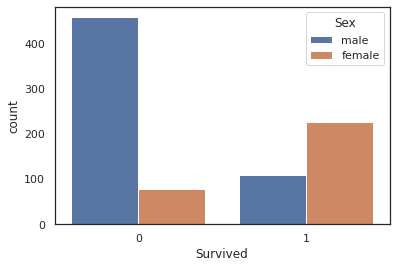

In [46]:
sns.countplot(data=train, x='Survived', hue='Sex')

In [47]:
train[["Sex", "Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.744262
male,0.190813


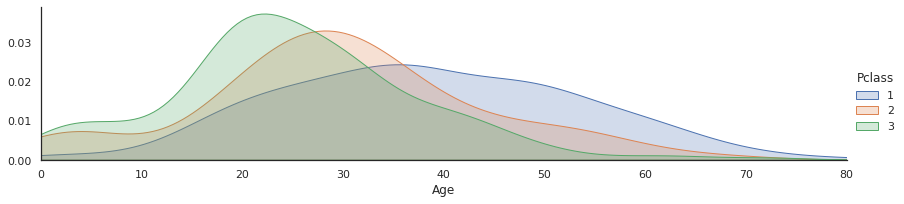

In [48]:
facet = sns.FacetGrid(train, hue="Pclass",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


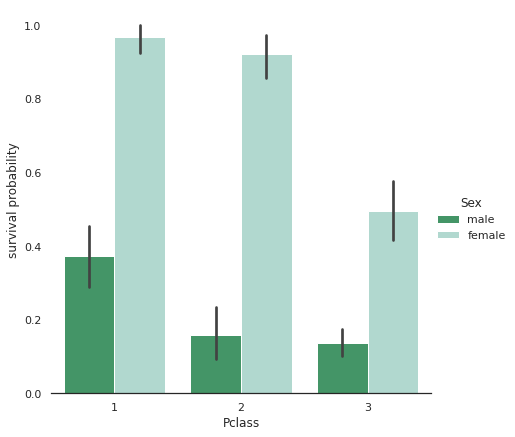

In [49]:
Survived_Pcalss = sns.factorplot(x="Pclass", y="Survived", 
                                 hue="Sex", data=train, size=6, 
                                 kind="bar", palette="BuGn_r")
Survived_Pcalss.despine(left=True)
Survived_Pcalss = Survived_Pcalss.set_ylabels("survival probability")

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


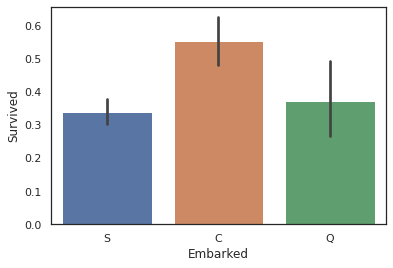

In [50]:
sns.barplot(dataset['Embarked'], dataset['Survived']);

In [51]:
print(dataset.groupby(['Embarked'])['PassengerId'].count())
dataset.groupby(['Embarked']).mean()

Embarked
C    270
Q    121
S    896
Name: PassengerId, dtype: int64


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male
Embarked,,,,,,,,
C,690.655556,0.553571,1.851852,31.242296,0.400000,0.370370,62.336267,0.581481
Q,676.669421,0.373333,2.892562,25.995868,0.330579,0.115702,12.356854,0.520661
S,647.803571,0.338658,2.342634,29.016462,0.486607,0.408482,26.418572,0.683036


In [52]:
print(dataset["Embarked"].isnull().sum())
dataset["Embarked"] = dataset["Embarked"].fillna("S")

2


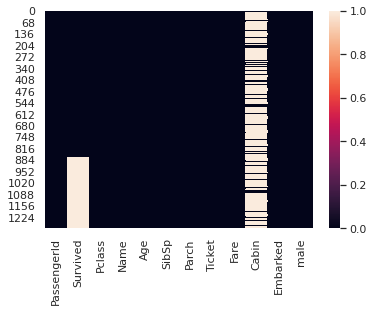

In [54]:
sns.heatmap(dataset.isnull())

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


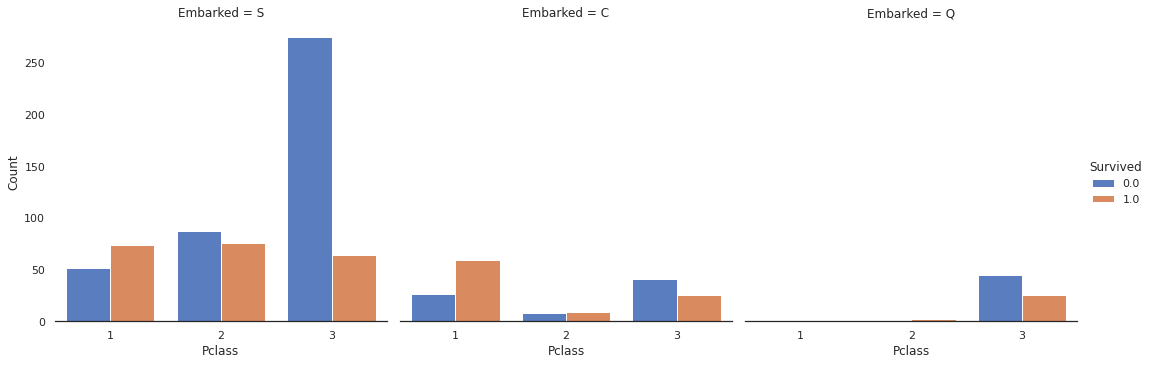

In [55]:
Embarked_Pc = sns.factorplot("Pclass", col="Embarked",  data=dataset,
                   size=5, kind="count", palette="muted", hue='Survived')

Embarked_Pc.despine(left=True)
Embarked_Pc = Embarked_Pc.set_ylabels("Count")

In [56]:
embarked = pd.get_dummies(dataset['Embarked'], drop_first = True)
dataset = pd.concat([dataset,embarked], axis = 1)
dataset.drop(['Embarked'] , axis = 1 , inplace = True)

In [57]:
dataset['Name'].head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [58]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].value_counts()

Mr              748
Miss            252
Mrs             196
Master           59
Rev               8
Dr                8
Col               4
Major             2
Mlle              2
Ms                2
Jonkheer          1
Dona              1
Sir               1
Lady              1
Mme               1
the Countess      1
Capt              1
Don               1
Name: Title, dtype: int64

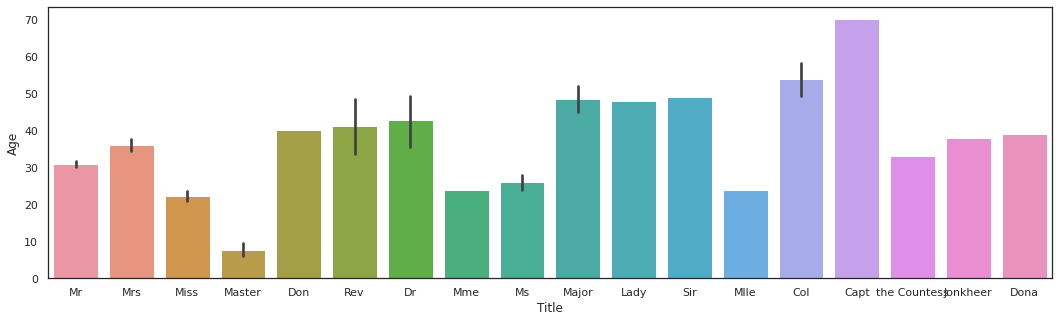

In [60]:
plt.figure(figsize=(18,5))
sns.barplot(x=dataset['Title'], y=dataset['Age'])

In [61]:
print(dataset.groupby('Title')['Age'].mean())

Title
Capt            70.000000
Col             54.000000
Don             40.000000
Dona            39.000000
Dr              42.750000
Jonkheer        38.000000
Lady            48.000000
Major           48.500000
Master           7.721695
Miss            22.319802
Mlle            24.000000
Mme             24.000000
Mr              30.908422
Mrs             35.989796
Ms              26.000000
Rev             41.250000
Sir             49.000000
the Countess    33.000000
Name: Age, dtype: float64


In [62]:
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess',
                                             'Capt', 'Col','Don', 'Dr', 
                                             'Major', 'Rev', 'Sir', 'Jonkheer',
                                             'Dona'], 'Rare')

dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 ,
                                         "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, 
                                         "Rare":3})

dataset["Title"] = dataset["Title"].astype(int)
dataset.drop(labels=["Name"], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


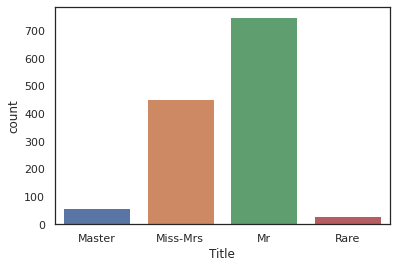

In [63]:
sns.countplot(dataset["Title"]).set_xticklabels(["Master","Miss-Mrs","Mr","Rare"]);

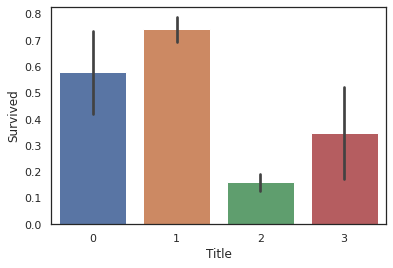

In [64]:
sns.barplot(x='Title', y='Survived', data=dataset);

In [65]:
dataset["Famize"] = dataset["SibSp"] + dataset["Parch"] + 1
dataset.drop(labels=["SibSp",'Parch'], axis=1, inplace=True)

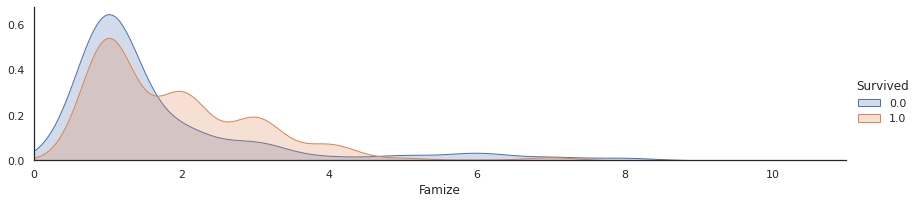

In [66]:
facet = sns.FacetGrid(dataset, hue="Survived", aspect=4)
facet.map(sns.kdeplot, 'Famize', shade=True)
facet.set(xlim=(0, dataset['Famize'].max()))
facet.add_legend()
plt.xlim(0);

In [67]:
dataset.drop(labels = ["Ticket",'Cabin','PassengerId'], axis = 1, 
             inplace = True)

In [68]:
train = dataset[:len(train)]
test = dataset[len(train):]
test.drop(labels=["Survived"],axis = 1,inplace = True)

Y_train = train["Survived"].astype(int)
X_train = train.drop(labels = ["Survived"],axis = 1)

K_fold = StratifiedKFold(n_splits=10)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Classificier

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


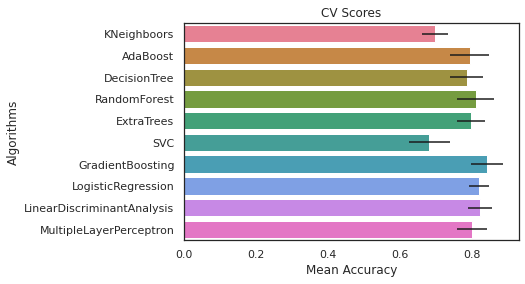

In [69]:
random_state = 2

models = []  
cv_results = []
cv_means = []
cv_std = []

models.append(KNeighborsClassifier())
models.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
models.append(DecisionTreeClassifier(random_state=random_state))
models.append(RandomForestClassifier(random_state=random_state))
models.append(ExtraTreesClassifier(random_state=random_state))
models.append(SVC(random_state=random_state))
models.append(GradientBoostingClassifier(random_state=random_state))
models.append(LogisticRegression(random_state = random_state))
models.append(LinearDiscriminantAnalysis())
models.append(MLPClassifier(random_state=random_state))


for model in models :
    cv_results.append(cross_val_score(model, X_train, Y_train, 
                                      scoring = "accuracy", cv = K_fold, n_jobs=4))

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_frame = pd.DataFrame(
    {
        "CrossValMeans":cv_means,
        "CrossValErrors": cv_std,
        "Algorithms":[
                     "KNeighboors",
                     "AdaBoost", 
                     "DecisionTree",   
                     "RandomForest",
                     "ExtraTrees",
                     "SVC",
                     "GradientBoosting",                      
                     "LogisticRegression",
                     "LinearDiscriminantAnalysis",
                     "MultipleLayerPerceptron"]
    })

cv_plot = sns.barplot("CrossValMeans","Algorithms", data = cv_frame,
                palette="husl", orient = "h", **{'xerr':cv_std})

cv_plot.set_xlabel("Mean Accuracy")
cv_plot = cv_plot.set_title("CV Scores")

In [70]:
GBC_Model = GradientBoostingClassifier()

scores = cross_val_score(GBC_Model, X_train, Y_train, cv=K_fold, n_jobs=4, scoring='accuracy')

print(scores)
round(np.mean(scores)*100, 2)

[0.81818182 0.81609195 0.79310345 0.89655172 0.91954023 0.86206897
 0.85057471 0.75862069 0.83908046 0.85057471]


84.04

In [71]:
LDA_Model= LinearDiscriminantAnalysis()

scores = cross_val_score(LDA_Model, X_train, Y_train, cv=K_fold, n_jobs=4, scoring='accuracy')

print(scores)
round(np.mean(scores)*100, 2)

[0.82954545 0.82758621 0.77011494 0.87356322 0.82758621 0.79310345
 0.79310345 0.7816092  0.86206897 0.85057471]


82.09

In [72]:
Log_Model = LogisticRegression(C=1)
scores = cross_val_score(Log_Model, X_train, Y_train, cv=K_fold, n_jobs=4, scoring='accuracy')

print(scores)
round(np.mean(scores)*100, 2)

[0.81818182 0.83908046 0.7816092  0.87356322 0.83908046 0.7816092
 0.79310345 0.8045977  0.83908046 0.82758621]


81.97

In [73]:
RFC_model = RandomForestClassifier(n_estimators=10)
scores = cross_val_score(RFC_model, X_train, Y_train, cv=K_fold, n_jobs=4, scoring='accuracy')

print(scores)
round(np.mean(scores)*100, 2)

[0.77272727 0.81609195 0.73563218 0.82758621 0.87356322 0.81609195
 0.81609195 0.71264368 0.81609195 0.86206897]


80.49

In [74]:
GNB_Model = GaussianNB()

scores = cross_val_score(GNB_Model, X_train, Y_train, cv=K_fold, 
                        n_jobs=4, scoring='accuracy')

print(scores)
round(np.mean(scores)*100, 2)

[0.78409091 0.81609195 0.75862069 0.86206897 0.7816092  0.79310345
 0.81609195 0.79310345 0.87356322 0.83908046]


81.17

In [75]:
SVM_Model = SVC()

scores = cross_val_score(SVM_Model, X_train, Y_train, cv=K_fold, 
                        n_jobs=4, scoring='accuracy')

print(scores)
round(np.mean(scores)*100, 2)

[0.59090909 0.56321839 0.72413793 0.75862069 0.66666667 0.70114943
 0.68965517 0.71264368 0.71264368 0.68965517]


68.09

# Hyperparameter Tuning 

In [76]:
GBC = GradientBoostingClassifier()
gb_param_grid = {
              'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01, 0.001],
              'max_depth': [4, 8,16],
              'min_samples_leaf': [100,150,250],
              'max_features': [0.3, 0.1]
              }

gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv=K_fold, scoring="accuracy", n_jobs=4, verbose=1)

gsGBC.fit(X_train,Y_train)
GBC_best = gsGBC.best_estimator_

gsGBC.best_score_

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done 300 tasks      | elapsed:   31.9s
[Parallel(n_jobs=4)]: Done 550 tasks      | elapsed:   56.2s
[Parallel(n_jobs=4)]: Done 900 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 1350 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 1900 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 2160 out of 2160 | elapsed:  3.6min finished


0.8347309299895507

In [77]:
RFC = RandomForestClassifier()

rf_param_grid = {"max_depth": [None],
              "min_samples_split": [2, 6, 20],
              "min_samples_leaf": [1, 4, 16],
              "n_estimators" :[100,200,300,400],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv=K_fold, scoring="accuracy", n_jobs=4, verbose=1)

gsRFC.fit(X_train,Y_train)
RFC_best = gsRFC.best_estimator_

gsRFC.best_score_

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   16.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:  2.2min finished


0.8404780564263323

In [78]:
LRM = LogisticRegression()

lr_param_grid = {"penalty" : ["l2"],
              "tol" : [0.0001,0.0002,0.0003],
              "max_iter": [100,200,300],
              "C" :[0.01, 0.1, 1, 10, 100],
              "intercept_scaling": [1, 2, 3, 4],
              "solver":['liblinear'],
              "verbose":[1]}


gsLRM = GridSearchCV(LRM, param_grid = lr_param_grid, cv=K_fold, scoring="accuracy", n_jobs=4, verbose=1)

gsLRM.fit(X_train,Y_train)
LRM_best = gsLRM.best_estimator_

gsLRM.best_score_

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 1400 tasks      | elapsed:   12.9s


[LibLinear]

[Parallel(n_jobs=4)]: Done 1800 out of 1800 | elapsed:   16.7s finished


0.8209247648902821

In [79]:
LDA = LinearDiscriminantAnalysis()

lda_param_grid = {"solver" : ["svd"],
              "tol" : [0.0001,0.0002,0.0003]}


gsLDA = GridSearchCV(LDA, param_grid = lda_param_grid, cv=K_fold,
                     scoring="accuracy", n_jobs= 4, verbose = 1)

gsLDA.fit(X_train,Y_train)
LDA_best = gsLDA.best_estimator_

gsLDA.best_score_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  23 out of  30 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.2s finished


0.820885579937304

In [80]:
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100, 200, 300]}

gsSVMC = GridSearchCV(SVMC, param_grid = svc_param_grid, cv = K_fold,
                      scoring="accuracy", n_jobs= -1, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

gsSVMC.best_score_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   52.3s finished


0.8151384535005224

In [81]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

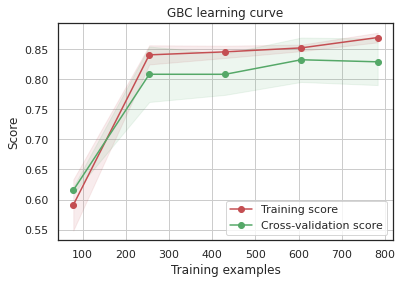

In [82]:
plot_learning_curve(estimator = gsGBC.best_estimator_,title = "GBC learning curve",
                    X = X_train, y = Y_train, cv = K_fold);

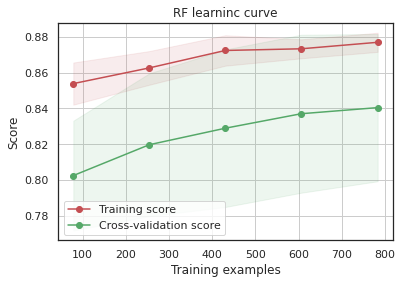

In [83]:
plot_learning_curve(estimator = gsRFC.best_estimator_ ,title = "RF learninc curve",
                    X = X_train, y = Y_train, cv = K_fold);

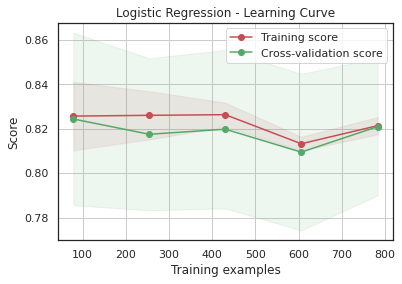

In [84]:
plot_learning_curve(estimator = Log_Model ,title = "Logistic Regression - Learning Curve",
                    X = X_train, y = Y_train, cv = K_fold);

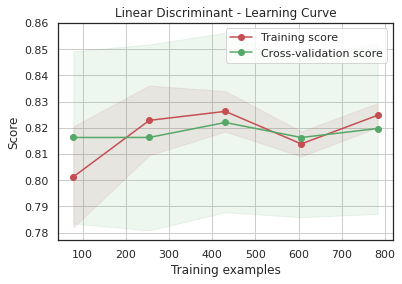

In [85]:
plot_learning_curve(estimator = gsLDA.best_estimator_ ,title = "Linear Discriminant - Learning Curve",
                    X = X_train, y = Y_train, cv = K_fold);

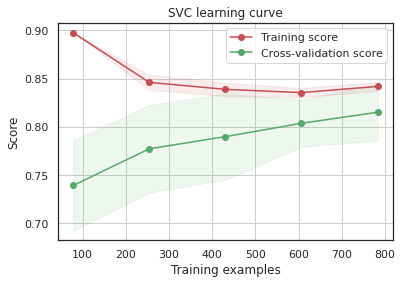

In [86]:
plot_learning_curve(estimator = gsSVMC.best_estimator_,title = "SVC learning curve",
                    X = X_train, y = Y_train, cv = K_fold);

# Ensemble modeling

In [87]:
VotingPredictor = VotingClassifier(estimators =
                           [('rfc', RFC_best), 
                            ('gbc', GBC_best)],
                           voting='soft', n_jobs = 4)

# VotingPredictor = VotingClassifier(estimators =
#                            [ ('rfc', RFC_best), 
#                             ('svc', SVMC_best),
#                             ('gbc', GBC_best),
#                             ('lda', LDA_best),
#                             ('lrm', LRM_best)],
#                            voting='soft', n_jobs = 4)

VotingPredictor = VotingPredictor.fit(X_train, Y_train)

scores = cross_val_score(VotingPredictor, X_train, Y_train, cv = K_fold,
                       n_jobs = 4, scoring = 'accuracy')
print(scores)
print(round(np.mean(scores)*100, 2))

[0.78409091 0.83908046 0.75862069 0.89655172 0.91954023 0.85057471
 0.83908046 0.77011494 0.88505747 0.85057471]
83.93


In [ ]:
plot_learning_curve(estimator = VotingPredictor, title = "VP learning curve",
                    X = X_train, y = Y_train, cv = K_fold);

In [88]:
Predictive_Model = pd.DataFrame({
        "PassengerId": TestPassengerID,
        "Survived": VotingPredictor.predict(test)})

Predictive_Model.to_csv('titanic_model.csv', index=False)

In [89]:
submission = pd.read_csv('titanic_model.csv')
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
